# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [1]:
# Import packages
import os 
from datetime import datetime
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import skewnorm
from scipy.stats import norm


In [2]:
# eigen packages modules
current_working_directory = os.getcwd()                                    
parent_working_directory = os.path.dirname(current_working_directory)      
scripts_directory = os.path.join(parent_working_directory, 'scripts')      
sys.path.append(scripts_directory)                                         
# sys.path.remove(scripts_directory) # in case neede to be removed
# print(sys.path)                    # in case needs to be inspected

import my_constants_standards as mycs
import my_matplotlib_standards as myms

In [3]:
# eigen standard set up uitvoering
mycs.my_colors_setup()
myms.my_matplotlib_pyplot_setup()

In [4]:
# Definieer data locaties
location = '../data/geboortes/'

#  om te saven als excel file, tussendtijds resultaat
location_save = '../data/interim/'

## Utilities

In [5]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

def bereken_gemiddelde(deviation, df_in):

    low_limit = 1 - deviation 
    high_limit = 1 + deviation 
    average = df_in['geboorte_datum'].groupby(df_in['geboorte_dag']).count().mean()
    average_lowlimit = average * low_limit
    average_highlimit = average * high_limit
    # print(average, average_highlimit, average_lowlimit)

    return average, average_highlimit, average_lowlimit

## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

In [6]:
#  opladen van de csv files
list_dfs = list()
list_wrong_dfs = list()

for file in os.listdir(location):

    file_to_load = os.path.join(location, f"{file}")
    df = pd.read_csv(file_to_load, delimiter=',')
    filename_without_extension = os.path.splitext(file)[0]
    df['file_date'] = filename_without_extension
    
    if filename_without_extension != '2019-2-29':
        list_dfs.append(df)
    else:
        list_wrong_dfs.append(df)    
    # break

df = pd.concat(list_dfs)

df_wrong = pd.concat(list_wrong_dfs)
df_wrong['reden_fout'] = '2019-02-29 datum bestaat niet'

del list_dfs
del list_wrong_dfs

In [7]:
# controle van de gegevens, geen nul, had ik kverwijderd blijkbaar
df.isnull().sum()

gemeente           0
naam               0
geslacht           0
verwachte datum    0
file_date          0
dtype: int64

In [8]:
#  voeg gegevens toe om verder te analyseren
df['geboorte_datum'] = pd.to_datetime(df['file_date'])
df['geboorte_dag'] = df['geboorte_datum'].dt.day_of_year
df['geboorte_weekdag'] = df['geboorte_datum'].dt.day_of_week
df['geboorte_week'] = df['geboorte_datum'].dt.isocalendar()['week']
df['geboorte_datum_verwacht'] = pd.to_datetime(df['verwachte datum'])

## Stap 2: Dagelijks aantal geboortes bekijken

#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

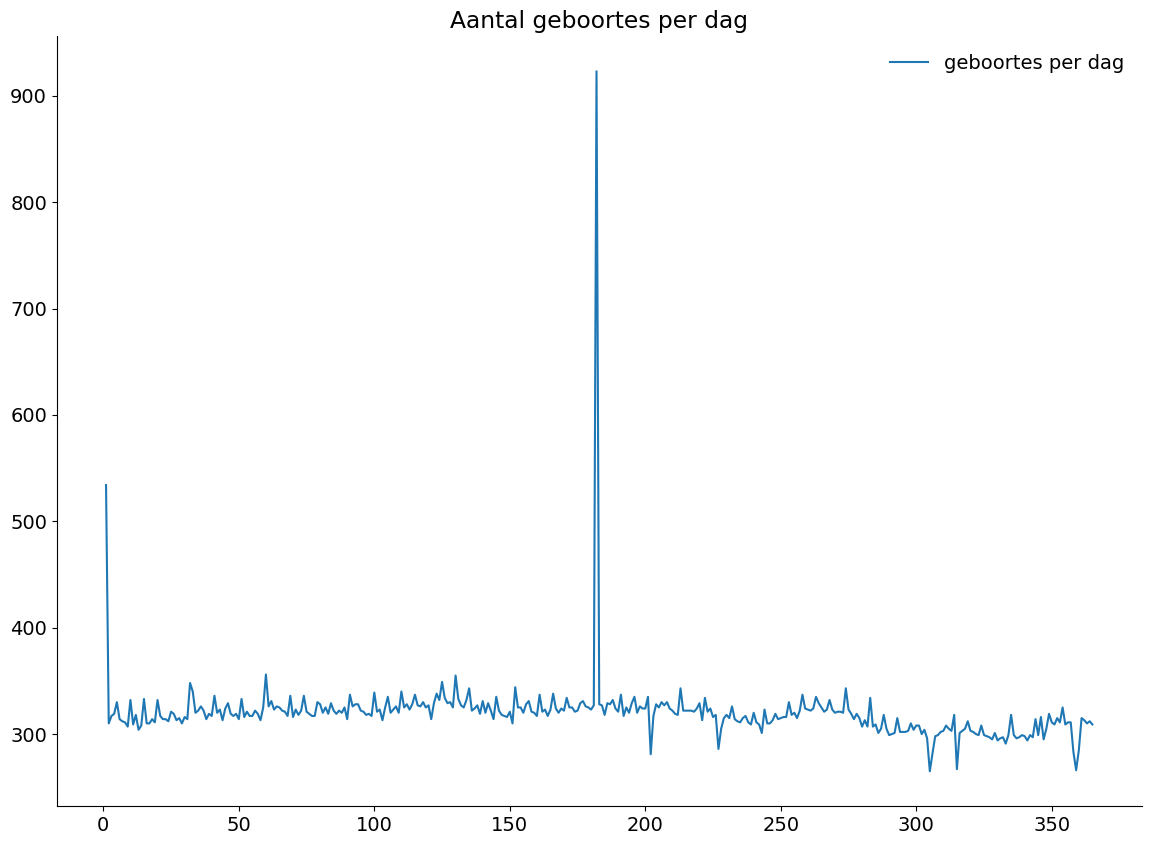

In [9]:
#  figuur aangepast met fig en ax
fig, ax = plt.subplots() 
ax.plot(df['geboorte_dag'].groupby(df['geboorte_dag']).count(), label='geboortes per dag')
plt.title('Aantal geboortes per dag')
plt.legend()
plt.show()

# plt.plot(df['geboorte_dag'].groupby(df['geboorte_dag']).count(), label='geboortes per dag')
# plt.xlabel('Geboortedag')
# plt.ylabel('Aantal geboortes')
# plt.title('Aantal geboortes per dag')
# plt.legend()
# plt.show()

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [10]:
#  bepaal gemiddelde, hig en low limiet, 10% afwijking
average, average_highlimit, average_lowlimit = bereken_gemiddelde(0.10, df) 
print(average, average_highlimit, average_lowlimit)

320.13698630136986 352.1506849315069 288.1232876712329


Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [11]:
#  afgewerkte versie van correctie, nu inclusief met correct gerapporteerde wrong gegevens
df_corrected = df[(df['geboorte_datum'] != '2019-01-01') & (df['geboorte_datum'] != '2019-07-01' )]
# df_corrected.info()

df_wrong = pd.concat([df_wrong, df[(df['geboorte_datum'] == '2019-01-01') | (df['geboorte_datum'] == '2019-07-01' )]])

df[(df['geboorte_datum'] == '2019-01-01') | (df['geboorte_datum'] == '2019-07-01' )]
df_wrong.loc[df_wrong['geboorte_datum'] == '2019-01-01', 'reden_fout' ] = '2019-01-01 outlier removal'
df_wrong.loc[df_wrong['geboorte_datum'] == '2019-07-01', 'reden_fout' ] = '2019-07-01 outlier removal'


Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

In [12]:
#  ipv df wordt nu df_corrected gebruikt
average, average_highlimit, average_lowlimit = bereken_gemiddelde(0.10, df_corrected) 
print(average, average_highlimit, average_lowlimit)

317.8870523415978 349.6757575757576 286.09834710743803


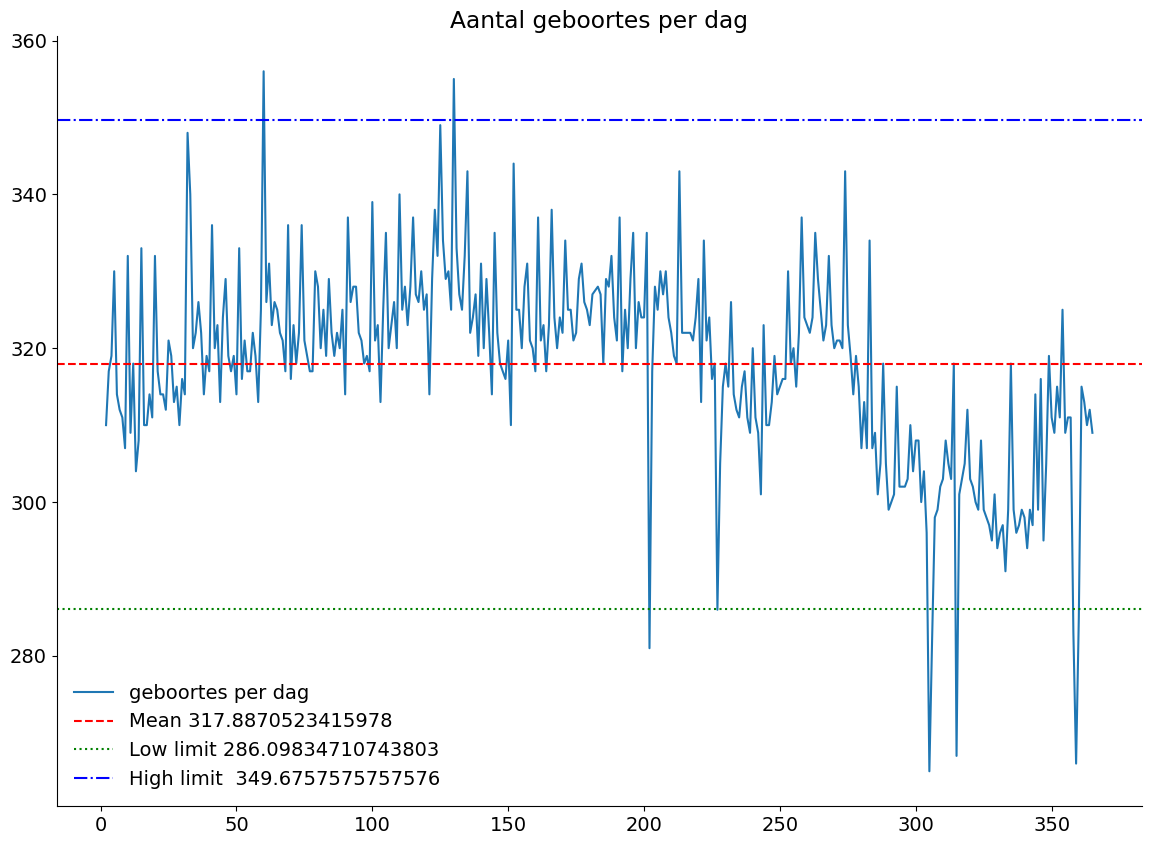

In [13]:
#  aangepast plot, met limieten t.o.v. gemiddelde
fig, ax = plt.subplots() 
ax.plot(df_corrected['geboorte_dag'].groupby(df_corrected['geboorte_dag']).count(), label='geboortes per dag')

ax.axhline(y=average, color='r', linestyle='--', label=f'Mean {average}')
ax.axhline(y=average_lowlimit, color='g', linestyle=':', label=f'Low limit {average_lowlimit}')
ax.axhline(y=average_highlimit, color='b', linestyle='-.', label=f'High limit  {average_highlimit}')

plt.title('Aantal geboortes per dag')
plt.legend()
plt.show()

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [14]:
# de geboortedag links met de outliers rechts
df_corrected_2nd_half = df_corrected[df_corrected['geboorte_datum'] >= '2019-07-01']
df_8_outliers = (df_corrected_2nd_half['geboorte_dag'].
    groupby(df_corrected_2nd_half['geboorte_dag']).
    count().sort_values(ascending=False).
    tail(8))
print(df_8_outliers)
del df_corrected_2nd_half

geboorte_dag
227    286
360    285
358    283
306    282
202    281
315    267
359    266
305    265
Name: geboorte_dag, dtype: int64


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

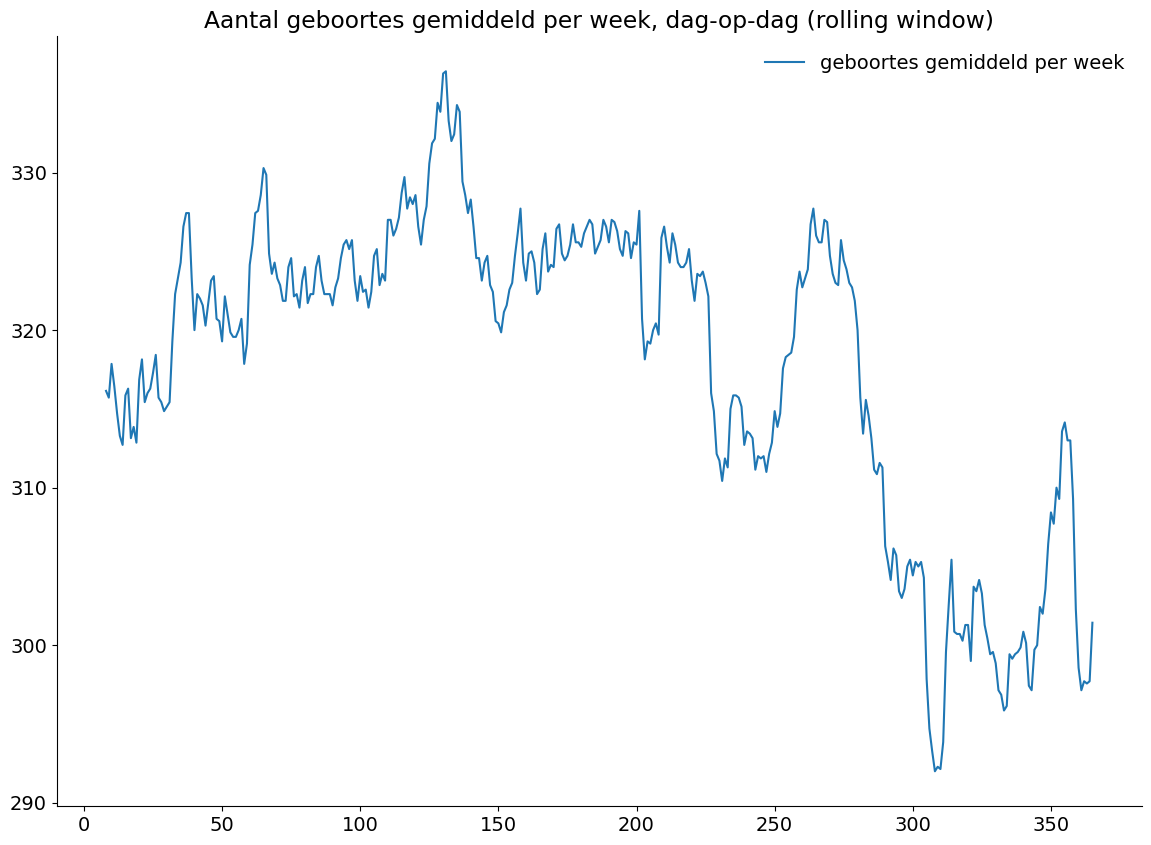

In [15]:
#  rolling average te berekenen blijkbaar
df_geboortes_per_dag = df_corrected['geboorte_dag'].groupby(df_corrected['geboorte_dag']).count().sort_index(ascending=True)
df_geboortes_per_dag_gemiddeld = df_geboortes_per_dag.rolling(window=7).mean()

fig, ax = plt.subplots() 
ax.plot(df_geboortes_per_dag_gemiddeld, label='geboortes gemiddeld per week')
plt.title('Aantal geboortes gemiddeld per week, dag-op-dag (rolling window)')
plt.legend()
plt.show()

del df_geboortes_per_dag
del df_geboortes_per_dag_gemiddeld

Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


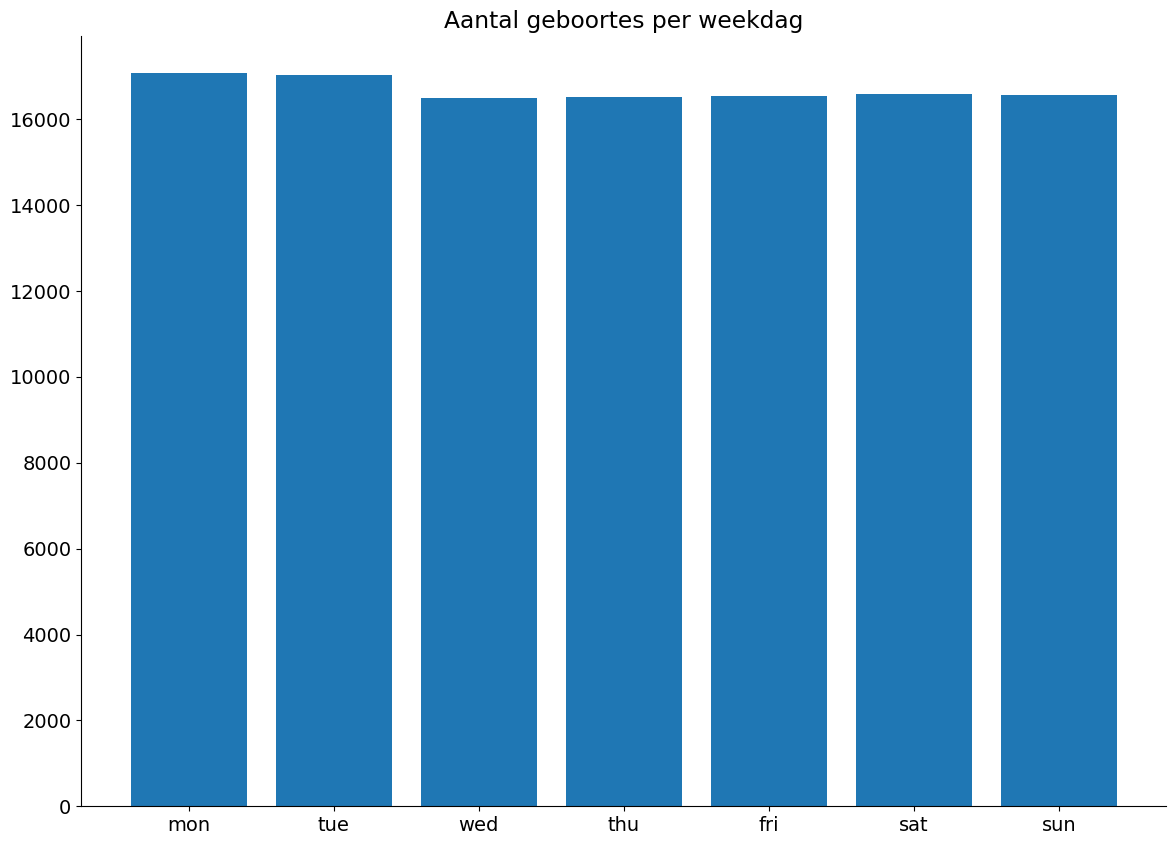

In [16]:
fig, ax = plt.subplots() 
ax.bar( ['mon','tue','wed','thu','fri','sat','sun',],
    df['geboorte_weekdag'].groupby(df['geboorte_weekdag']).count().sort_index(ascending=True))
# 0 = mon, 6 = sun
plt.title('Aantal geboortes per weekdag')
plt.legend()
plt.show()

In [17]:
# bestandsnaam = os.path.join(location_save, "df_corrected.xlsx")
# df_corrected.to_excel(bestandsnaam, index=False)

# Deel 2
## Introductie

## Stap 1 : verder werken 1